In [1]:
import pandas as pd
import deepxde as dde
import numpy as np
import re
import matplotlib.pyplot as plt
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
Kt = dde.Variable(1.0)
Rs = dde.Variable(1.0)
Rsh = dde.Variable(1.0)
Iso = dde.Variable(1.0)

In [3]:
Var_list = [Kt, Rs, Rsh, Iso]

In [4]:
# '''
# 24th July, 2023 created by Likun Chen, Wuhan University
# This is for testing the PINN parameter estimation, object: syn-machine
# EXT Parameters:
#     Vi , initial terminal voltage : 1.0 pu
#     Ta , voltage regulator time constant : 0.4 sec
#     Kf , rate feedback gain : 0.03
# SYN Parameters:
#     H , inertia constant : 1.7 MWs/MVA
#     D , synchronous mechanical damping : 0.12 pu/pu
#     Xa , stator leakage reactance : 0.130 pu
#     Xd , d-axis unsaturated reactance : 1.79 pu
#     Xd' , d-axis unsaturated transient reactance : 0.169 pu
#     Xd'' , d-axis unsaturated Sub-Trans reactance : 0.135 pu
#     Xq , q-axis unsaturated reactance : 1.71 pu
#     Xq' , q-axis unsaturated transient reactance : 0.228 pu
#     Xq'' , q-axis unsaturated Sub-Trans reactance : 0.2 pu
# For 2-order equation, the state variables are rev (w) and phase angle (delta), 
# parameters waiting estimated are H , D , Eq' = Ed' = const
#     H * d2_delta/dt2 (This is dw/dt) + D * d_delta/dt + P_ex - P_mach = 0
#     P_ex is external power balance and P_mach is the mechanical power
#     time， P_ex, delta, P_mach, dw
# '''

In [5]:
input_data = pd.read_csv('data/1011PVtest.csv')
input_data

,Time,Subsystem #1|Node Voltages|S1) VDCpA8,Subsystem #1|PV|Array1A|IPVAxxx,Subsystem #1|PV|Array1A|Io1PV
0,0.00000,2.462654,0.001231,5.109490e-12
1,0.00005,2.462654,0.001231,5.109490e-12
2,0.00010,2.462654,0.001231,5.109490e-12
3,0.00015,2.462654,0.001231,5.109490e-12
4,0.00020,2.462654,0.001231,5.109490e-12
...,...,...,...,...
7995,0.39975,2.027442,0.157634,5.109490e-12
7996,0.39980,2.027442,0.157634,5.109490e-12
7997,0.39985,2.027440,0.157634,5.109490e-12
7998,0.39990,2.027438,0.157634,5.109490e-12


In [6]:
step_time = input_data.Time[1] - input_data.Time[0]
st = 0.4 # start time (10% proportion)
et = 0.6 # end time
input_data.Time -= step_time * int(input_data.shape[0] * st)
input_data = input_data[int(input_data.shape[0]*st): int(input_data.shape[0]*et)]

In [6]:
input_data.columns = ['Time', 'V', 'I', 'Is']
input_data.drop(columns='Is', inplace=True)
input_data.set_index('Time', inplace=True)
input_data

,V,I
Time,,
0.00000,2.462654,0.001231
0.00005,2.462654,0.001231
0.00010,2.462654,0.001231
0.00015,2.462654,0.001231
0.00020,2.462654,0.001231
...,...,...
0.39975,2.027442,0.157634
0.39980,2.027442,0.157634
0.39985,2.027440,0.157634


In [7]:
step_time = input_data.index[1] - input_data.index[0]

In [8]:
step_time

5e-05

In [9]:
dI_dt = (input_data.I.to_numpy()[2:] - input_data.I.to_numpy()[:-2]) / step_time / 2

In [12]:
dV_dt = (input_data.V.to_numpy()[2:] - input_data.V.to_numpy()[:-2]) / step_time / 2

In [45]:
# Kt, Rs, Rsh, Iso
Kt = 24.5
Rs = -13.7
Rsh = -28.3
Iso = 1.76

In [46]:
left = 1 + Iso*Rs/Kt*np.exp((input_data.V.to_numpy()[1:-1]+input_data.I.to_numpy()[1:-1]*Rs)/Kt)  + Rs/Rsh
left*dI_dt

array([ 0.        ,  0.        ,  0.        , ..., -0.00034709,
        0.00047188,  0.00139949])

In [47]:
right = - dV_dt * (Iso/Kt*np.exp((input_data.V.to_numpy()[1:-1]+input_data.I.to_numpy()[1:-1]*Rs)/Kt) + 1/Rsh)

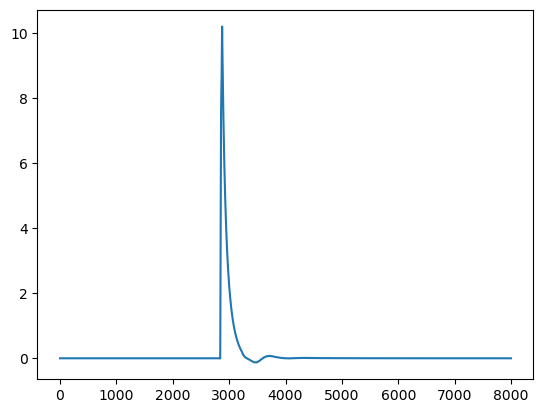

In [48]:
plt.plot(left*dI_dt - right)

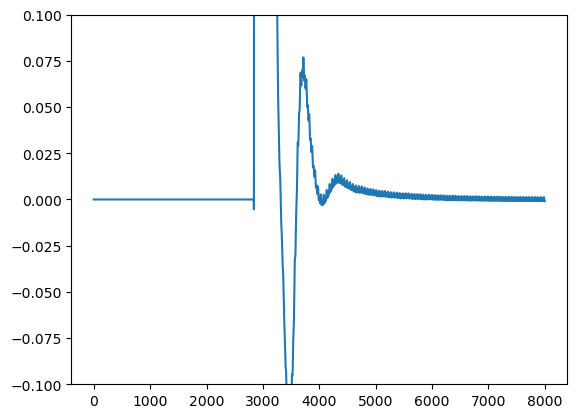

In [49]:
plt.figure()
plt.plot(left*dI_dt - right)
plt.ylim((-0.1, 0.1))
plt.show()



In [8]:
weight_list = (1 / input_data.describe().loc['mean']).tolist()
weight_list

[0.480310405769598, 6.546099961178032]

<Axes: xlabel='Time'>

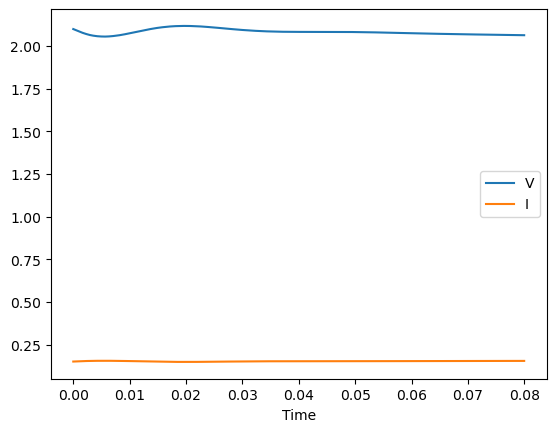

In [9]:
input_data.plot()

In [10]:
x = input_data.index.to_numpy()
x

array([0.000e+00, 5.000e-05, 1.000e-04, ..., 7.985e-02, 7.990e-02,
       7.995e-02])

In [11]:
geom = dde.geometry.TimeDomain(0, x[-1])

In [12]:
# def boundary(_, on_initial):
#     return on_initial

In [13]:
# x0 = input_data.iloc[0].tolist()

In [14]:
# # Initial conditions
# ic1 = dde.icbc.IC(geom, lambda X: x0[0], boundary, component=0)
# ic2 = dde.icbc.IC(geom, lambda X: x0[1], boundary, component=1)
# ic3 = dde.icbc.IC(geom, lambda X: x0[2], boundary, component=2)

In [15]:
y = input_data.to_numpy()
y.shape

(1600, 2)

In [16]:
observe_t = x.reshape(-1, 1)

In [17]:
# Get the training data
observe_y0 = dde.icbc.PointSetBC(observe_t, y[:, 0:1], component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, y[:, 1:2], component=1)
# observe_y2 = dde.icbc.PointSetBC(observe_t, y[:, 2:3], component=2)

In [18]:
# Kt = dde.Variable(0.0)
# Rs = dde.Variable(0.0)
# Rsh = dde.Variable(0.0)
def Microgrid_system(x, y):
    """Modified Lorenz system (with exogenous input).
    H * d2_delta/dt2 (This is dw/dt) + D * d_delta/dt + P_ex - P_mach = 0
    """
    V, I = y[:, 0:1], y[:, 1:2]
    
    
    dV_dt = dde.grad.jacobian(y, x, i=0)
    dI_dt = dde.grad.jacobian(y, x, i=1)

    left = 1 + Iso*Rs/Kt*tf.exp((V+I*Rs)/Kt)  + Rs/Rsh
    right = - dV_dt / dI_dt * (Iso/Kt*tf.exp((Rs*I+V)/Kt) + 1/Rsh)
    
    return [
        left - right
    ]


In [19]:
data = dde.data.PDE(
    geom,
    Microgrid_system,
    [observe_y0, observe_y1],
    anchors=observe_t,
)

In [20]:
net = dde.nn.FNN([1] + [128] * 3 + [2], "swish", "Glorot normal")

In [21]:
data_y = y
data_t = x

In [22]:
y.shape

(1600, 2)

In [23]:
def feature_transform(t):
    t = 0.01 * t
    return tf.concat(
        (tf.sin(t), tf.sin(2 * t)),
        axis=1,
    )

net.apply_feature_transform(feature_transform)

def output_transform(t, y):
    idx = data_y.shape[0]-1
    k = (data_y[idx] - data_y[0]) / (data_t[idx] - data_t[0])
    b = (data_t[idx] * data_y[0] - data_t[0] * data_y[idx]) / (
        data_t[idx] - data_t[0]
    )
    linear = k * t + b
    factor = tf.math.tanh(t) * tf.math.tanh(idx - t)
    return linear + factor * tf.constant([1., 1.]) * y

net.apply_output_transform(output_transform)

In [24]:

model = dde.Model(data, net)
model.compile("adam", lr=0.001, loss_weights=weight_list + [1e-2], external_trainable_variables=Var_list)



Compiling model...
Building feed-forward neural network...
'build' took 0.065771 s



D:\anaconda3\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.042545 s



In [25]:
fnamevar = "variables_testclk1.dat"
variable = dde.callbacks.VariableValue(Var_list, period=1000, filename=fnamevar)
model.train(iterations=100000, callbacks=[variable])

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.63e+03, 1.49e-03, 2.59e-08]    [3.63e+03, 1.49e-03, 2.59e-08]    []  
1000      [4.06e-05, 1.44e-03, 2.24e-06]    [4.06e-05, 1.44e-03, 2.24e-06]    []  
2000      [3.86e-05, 1.44e-03, 2.24e-06]    [3.86e-05, 1.44e-03, 2.24e-06]    []  
3000      [3.55e-05, 1.44e-03, 2.24e-06]    [3.55e-05, 1.44e-03, 2.24e-06]    []  
4000      [3.10e-05, 1.44e-03, 2.24e-06]    [3.10e-05, 1.44e-03, 2.24e-06]    []  
5000      [2.55e-05, 1.44e-03, 2.23e-06]    [2.55e-05, 1.44e-03, 2.23e-06]    []  
6000      [1.98e-05, 1.44e-03, 2.23e-06]    [1.98e-05, 1.44e-03, 2.23e-06]    []  
7000      [1.55e-05, 1.44e-03, 2.22e-06]    [1.55e-05, 1.44e-03, 2.22e-06]    []  
8000      [1.35e-05, 1.44e-03, 2.21e-06]    [1.35e-05, 1.44e-03, 2.21e-06]    []  
9000      [1.32e-05, 1.44e-03, 2.20e-06]    [1.32e-05, 1.44e-03, 2.20e-06]    []  
10000     [1.33e-05, 1.44e-03, 2.18

KeyboardInterrupt: 

In [26]:
lines = open(fnamevar, "r").readlines()
# read output data in fnamevar (this line is a long story...)
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

In [27]:
Chat[-10:, :]

array([[1.06 , 0.975, 1.07 , 0.934],
       [1.07 , 0.973, 1.08 , 0.923],
       [1.09 , 0.97 , 1.1  , 0.906],
       [1.1  , 0.968, 1.11 , 0.889],
       [1.12 , 0.965, 1.13 , 0.876],
       [1.13 , 0.963, 1.14 , 0.864],
       [1.14 , 0.961, 1.15 , 0.852],
       [1.15 , 0.959, 1.16 , 0.838],
       [1.16 , 0.956, 1.18 , 0.828],
       [1.17 , 0.955, 1.18 , 0.819]])

In [38]:
# Var_list = [Kt, Rs, Rsh, Iso]

Text(0.5, 0, 'Epoch')

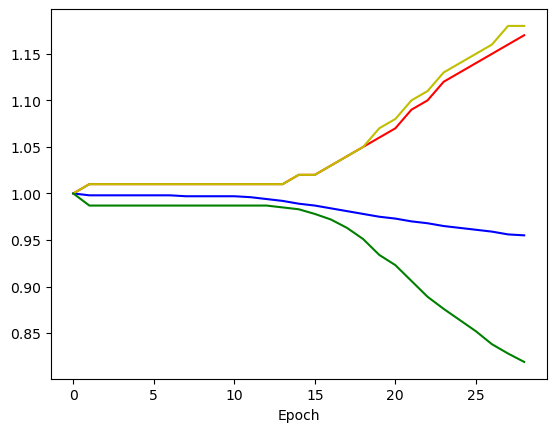

In [35]:
l, c = Chat.shape
plt.plot(range(l), Chat[:, 0], "r-")
plt.plot(range(l), Chat[:, 1], "b-")
plt.plot(range(l), Chat[:, 2], "y-")
plt.plot(range(l), Chat[:, 3], "g-")
# plt.plot(range(l), np.ones(Chat[:, 0].shape) * 1.5, "r--")
# plt.plot(range(l), np.ones(Chat[:, 1].shape) * 0.15, "b--")
# plt.legend(["H","D","True H","True D"], loc="right")
plt.xlabel("Epoch")

In [29]:
Chat[-10:, 0:2]

array([[1.06 , 0.975],
       [1.07 , 0.973],
       [1.09 , 0.97 ],
       [1.1  , 0.968],
       [1.12 , 0.965],
       [1.13 , 0.963],
       [1.14 , 0.961],
       [1.15 , 0.959],
       [1.16 , 0.956],
       [1.17 , 0.955]])

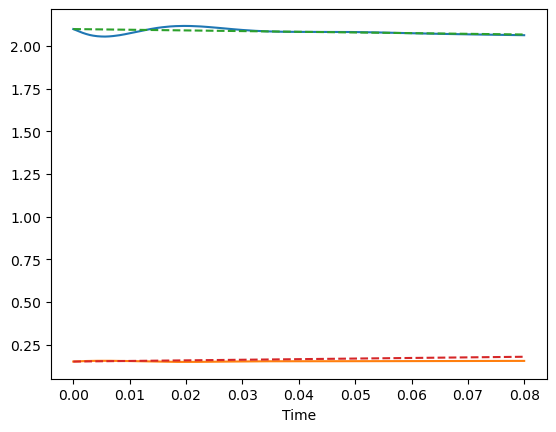

In [30]:
yhat = model.predict(observe_t)
plt.figure()
plt.plot(observe_t, y, "-", observe_t, yhat, "--")
plt.xlabel("Time")
# plt.legend(["x", "y", "z", "xh", "yh", "zh"])
# plt.title("Training data")
plt.show()